# Departamento de Engenharia de Teleinformática
# Curso de Graduação em Engenharia de Telecomuniucações
# TI0077 - Inteligência Computacional Aplicada
## Homework 02 - Models for regression - Part 2/2

Parte 1 questão 0: [Parte 1: Pré-processamento](preprocessing_data_hw02.ipynb)

### Alunos:

- Ezequias Márcio Silva de Santana Júnior - 371887
- Ingrid Simões Moreira Furtado - 375147
- Yuri Sales Ribeiro - 375177

#### Observações:
Para utilizar esse notebook é necessario ter Python3 instalado, juntamente com os pacotes listados abaixo:

- `numpy 1.16.2`
- `pandas 0.24.2`
- `matplotlib 3.0.3`
- `seaborn 0.9.0`
- `scipy 1.2.2`
- `scikit-learn 0.21.3`  

Este notebook, os dados utilizados e eventuais tabelas e figuras salvas encontam-se disponiveis no seguinte 
repositório: https://github.com/ezequiasjunior/ica2019.2

Ao executar este notebook localmente, serão gerados arquivos ```.pdf``` e tabelas ```.tex```.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
sns.set_style("whitegrid")
# np.set_printoptions(5)

In [2]:
# Usefull funtions:
def unc_monovar(data):
    #  Display the unconditional mono-variate analysis of a given data
    data_desc = data.describe().T
    data_desc.insert(3, 'skewness', data.skew())
    display(data_desc)

### Carregando o conjunto de treino e de validação

Como resultado do notebook da parte 1, os conjuntos de treino e validação transformados junto com suas respectivas saídas Y são carregados nas cálulas abaixo.

 São $D = 6$ preditores com $N = 40824$ observações no conjunto de treino e $N =4537$ no conjunto de validação.

In [3]:
# Loading transformed predictors data:
mos_trainX = pd.read_excel('hw2-data/X_mos_training.xlsx')#Xtrans_mos_train.xlsx') #2/3
# Loading outcome data:
mos_trainY = pd.read_excel('hw2-data/Y_mos_training.xlsx')#Y_mos_train.xlsx') #2/3
# Info:
unc_monovar(mos_trainX)
unc_monovar(mos_trainY)

,count,mean,std,skewness,min,25%,50%,75%,max
Test Hour,40824.0,5.609244e-13,1.0,-0.228283,-2.071230,-0.690076,0.129795,0.774100,1.726751
Signal (dBm),40824.0,-3.264810e-13,1.0,0.047252,-3.469940,-0.707308,-0.056018,0.732435,1.636566
Speed (m/s),40824.0,2.817147e-15,1.0,0.688033,-0.760090,-0.760090,-0.760090,1.172680,1.676465
Distance from site (m),40824.0,6.659588e-14,1.0,-0.021276,-2.419142,-0.682472,0.037255,0.719762,2.834735
Call Test Duration (s),40824.0,-1.320513e-11,1.0,0.004881,-2.201598,-0.997375,-0.997375,1.002898,1.002898
Call Test Setup Time (s),40824.0,2.817698e-15,1.0,2.200135,-2.346708,-0.061277,0.170190,0.424873,35.353997


,count,mean,std,skewness,min,25%,50%,75%,max
MOS,40824.0,2.509039,1.107205,0.266005,1.0,2.1,2.7,2.7,4.4


In [4]:
# Loading the transformed validation dataset:
mos_X = pd.read_excel('hw2-data/X_mos_validalidation.xlsx')#Xtrans_mos_valid.xlsx') #2/3
# Loading outcome validation data:
mos_Y = pd.read_excel('hw2-data/Y_mos_validation.xlsx')#Y_mos_valid.xlsx') #2/3
# Info:
unc_monovar(mos_X)
unc_monovar(mos_Y)

,count,mean,std,skewness,min,25%,50%,75%,max
Test Hour,4537.0,-3.178125e-14,1.0,-0.232338,-2.069065,-0.704283,0.112778,0.756753,1.711159
Signal (dBm),4537.0,-1.656672e-14,1.0,0.047198,-3.424822,-0.730599,-0.064708,0.732391,1.631959
Speed (m/s),4537.0,-7.994242e-16,1.0,0.685457,-0.760767,-0.760767,-0.760767,1.166389,1.670195
Distance from site (m),4537.0,2.562616e-15,1.0,-0.022594,-2.448827,-0.707874,0.042352,0.719309,2.811050
Call Test Duration (s),4537.0,4.238955e-13,1.0,-0.022442,-1.087703,-1.011115,0.975022,0.989245,0.989245
Call Test Setup Time (s),4537.0,1.235042e-14,1.0,1.692874,-2.360090,-0.024395,0.179242,0.407238,19.760145


,count,mean,std,skewness,min,25%,50%,75%,max
MOS,4537.0,2.522812,1.106716,0.26751,1.0,2.1,2.7,2.7,4.4


### Regressão linear - Ordinary Least Squares

Na célula abaixo, é feita a regressão linear para construir o modelo de predição $Y = X\beta + \epsilon$, utilizando o conjunto de módulos do pacote Scikit Learn que calcula os coeficientes do modelo usando: $$\hat{\beta} = (X^{T}X)^{-1}X^{T}Y$$

In [5]:
# Build the model:
ols = linear_model.LinearRegression()
# Model fitting using the training set:
ols.fit(mos_trainX.values, mos_trainY.values)
# Model output: estimated coeff. independent term + D=6 weigths
ols_beta = np.hstack([ols.intercept_[:, np.newaxis], ols.coef_]) 

# Testing the model:
# Estimate the outcome using the validation set: real data = mos_Y
ols_Y = ols.predict(mos_X.values)
# Compute the RMSE and the R2 scores using scikit-learn built-in functions
ols_rmse = np.sqrt(mean_squared_error(mos_Y, ols_Y))
ols_r2 = r2_score(mos_Y, ols_Y)

# Cross validation scheme: considering k=10 (N >10e3 samples)
ols_cv_r2 = cross_val_score(ols, mos_trainX.values, mos_trainY.values, cv=10)
ols_cv_rmse = cross_val_score(ols, mos_trainX.values, mos_trainY.values, 
                                   scoring='neg_mean_squared_error',cv=10)
ols_cv_rmse = np.sqrt(-ols_cv_rmse)

# View results:
print(f'''OLS model coefficients.: b0, ..., b6\n
{ols_beta.T}\n
OLS performance - validation set:\n
RMSE: {ols_rmse}
R2: {ols_r2}\n
Residuals:\n {(mos_Y - ols_Y).describe()}\n 
OLS 10-fold CV R2 performance: (training set)\n\n{ols_cv_r2}
mean: {ols_cv_r2.mean()}\n
OLS 10-fold CV RMSE performance: (training set)\n\n{ols_cv_rmse}
mean: {ols_cv_rmse.mean()}''')

OLS model coefficients.: b0, ..., b6

[[ 2.50903880e+00]
 [-1.84091190e-03]
 [ 2.10046277e-01]
 [ 3.97094590e-02]
 [ 1.05922088e-01]
 [-1.62946684e-01]
 [ 4.79486047e-02]]

OLS performance - validation set:

RMSE: 1.0844609969725199
R2: 0.039602730560349575

Residuals:
                MOS
count  4537.000000
mean      0.013774
std       1.084493
min      -2.292750
25%      -0.590740
50%      -0.001342
75%       0.454471
max       2.505490
 
OLS 10-fold CV R2 performance: (training set)

[0.04098662 0.04038959 0.02618048 0.03824233 0.03959815 0.03273559
 0.04003435 0.04024969 0.0351543  0.03757413]
mean: 0.03711452276106875

OLS 10-fold CV RMSE performance: (training set)

[1.09450206 1.09210763 1.08188607 1.0895453  1.07817864 1.06626286
 1.09853912 1.07156401 1.09354745 1.09685546]
mean: 1.0862988595481644


### Regressão linear com restrição L2 - Ridge

Na célula abaixo, é feita a regressão linear para construir o modelo de predição, utilizando o conjunto de módulos do pacote Scikit Learn que calcula os coeficientes do modelo usando a abordagem com restrição L-2: $$\hat{\beta} = (X^{T}X -\lambda I)^{-1}X^{T}Y$$

onde $\lambda$ é o hiperparâmetro a ser otimizado.

In [6]:
# Build the model: default lambda = 1 
ridge = linear_model.Ridge()
# Model fitting using the training set:
ridge.fit(mos_trainX.values, mos_trainY.values)
# Model output: estimated coeff. independent term + D=6 weigths
ridge_beta = np.hstack([ridge.intercept_[:, np.newaxis], ridge.coef_]) 

# Testing the model:
# Estimate the outcome using the validation set: real data = mos_Y
ridge_Y = ridge.predict(mos_X.values)
# Compute the RMSE and the R2 scores using scikit-learn built-in functions
ridge_rmse = np.sqrt(mean_squared_error(mos_Y, ridge_Y))
ridge_r2 = r2_score(mos_Y, ridge_Y)

# View results:
print(f'''Ridge model coefficients.: b0, ..., b6 (lambda = 1)\n
{ridge_beta.T}\n
Ridge performance - validation set:\n
RMSE: {ridge_rmse}
R2: {ridge_r2}\n
Residuals:\n {(mos_Y - ridge_Y).describe()}''')

Ridge model coefficients.: b0, ..., b6 (lambda = 1)

[[ 2.50903880e+00]
 [-1.83929483e-03]
 [ 2.10036740e-01]
 [ 3.97102645e-02]
 [ 1.05915184e-01]
 [-1.62936156e-01]
 [ 4.79457349e-02]]

Ridge performance - validation set:

RMSE: 1.0844609727031376
R2: 0.03960277354621666

Residuals:
                MOS
count  4537.000000
mean      0.013774
std       1.084493
min      -2.292713
25%      -0.590736
50%      -0.001337
75%       0.454462
max       2.505457


### Busca pelo hiperparâmetro $\lambda$

Ná célula abaixo, é feita a busca pelo hiperparâmetro $\lambda$ que leva á um RMSE mínimo, utilizando o processo de validação cruzada com o conjunto de dados particionado em $k=10$ $\textit{folds}$ e, em seguida, extraindo o valor graficamente.

In [19]:
# Range of hyperparam. lambda [0, 70]:
lambd = np.linspace(0, 70, 100)
# Variables for mean of CV metrics:
cv_rmse = np.zeros(lambd.size)
cv_r2 = np.zeros(lambd.size)
# Perform CV profile:
for idx, l in enumerate(lambd):
    # Build the model: lambda = l
    cv_ridge = linear_model.Ridge(alpha=l)
    # Cross validation scheme: considering k=10
    cv_r2[idx] = cross_val_score(cv_ridge, mos_trainX.values, mos_trainY.values, cv=10).mean()
    cv_ridge_rmse = cross_val_score(cv_ridge, mos_trainX.values, mos_trainY.values, 
                                         scoring='neg_mean_squared_error',cv=10).mean()
    cv_rmse[idx] = np.sqrt(-cv_ridge_rmse)

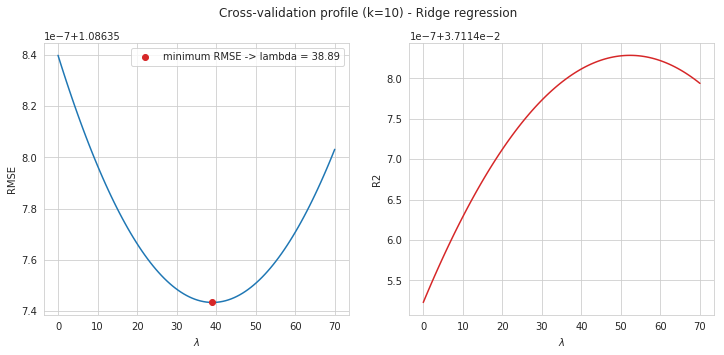

In [20]:
# Process report: plot cross-validation profile:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plt.suptitle('Cross-validation profile (k=10) - Ridge regression')
ax[0].plot(lambd, cv_rmse,'C0-') # rmse
ax[0].set_xlabel('$\lambda$')
ax[0].set_ylabel('RMSE')
ax[0].plot(lambd[np.argmin(cv_rmse)], np.min(cv_rmse), 'C3o', 
           label=f'minimum RMSE -> lambda = {lambd[np.argmin(cv_rmse)]:.4}') # minimum rmse point
ax[0].legend()
ax[1].plot(lambd, cv_r2,'C3-') # r2
ax[1].set_xlabel('$\lambda$')
ax[1].set_ylabel('R2')
plt.show()
fig.savefig('hw02-figs/CV_ridgelambda.pdf')

Como visto no resultado acima, o menor RMSE é alcançado quando $\lambda = 38.89$. Aplicando o modelo de regressão 
Ridge para o hiperparâmetro encontrado no conjunto de validação, tem-se:

In [21]:
# Build the model with lambda opt = 38.89 58.38 
ridge_opt = linear_model.Ridge(alpha=lambd[np.argmin(cv_rmse)])
# Model fitting using the training set:
ridge_opt.fit(mos_trainX.values, mos_trainY.values)
# Model output: estimated coeff. independent term + D=6 weigths
ridge_opt_beta = np.hstack([ridge_opt.intercept_[:, np.newaxis], ridge_opt.coef_]) 

# Testing the model:
# Estimate the outcome using the validation set: real data = mos_Y
ridge_opt_Y = ridge_opt.predict(mos_X.values)
# Compute the RMSE and the R2 scores using scikit-learn built-in functions
ridge_opt_rmse = np.sqrt(mean_squared_error(mos_Y, ridge_opt_Y))
ridge_opt_r2 = r2_score(mos_Y, ridge_opt_Y)

# View results:
print(f'''Ridge model coefficients.: b0, ..., b6 (lambda = {lambd[np.argmin(cv_rmse)]:.4})\n
{ridge_opt_beta.T}\n
Ridge performance - validation set:\n
RMSE: {ridge_opt_rmse}
R2: {ridge_opt_r2}\n
Residuals:\n {(mos_Y - ridge_opt_Y).describe()}''')

Ridge model coefficients.: b0, ..., b6 (lambda = 38.89)

[[ 2.50903880e+00]
 [-1.77821019e-03]
 [ 2.09676126e-01]
 [ 3.97405977e-02]
 [ 1.05654242e-01]
 [-1.62538246e-01]
 [ 4.78372622e-02]]

Ridge performance - validation set:

RMSE: 1.0844601343159075
R2: 0.039604258494922995

Residuals:
                  MOS
count  4537.00000000
mean      0.01377363
std       1.08449218
min      -2.29133068
25%      -0.59060925
50%      -0.00115180
75%       0.45420129
max       2.50420602


### Modelos com redução de dimensionalidade: PLS e PCR

Nas células abaixo, serão implementados os modelos Partial least-squares e Principal-component regression a fim de traçar um comparativo da performance com relação ao teste de modelo com o uso do conjunto de dados de validação.

### PCR

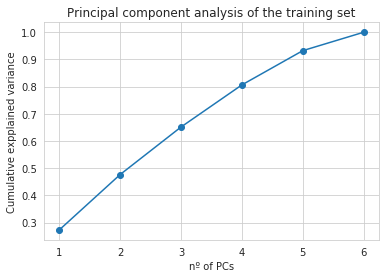

In [10]:
# Principal component analysis of the training set:
pca = PCA(n_components=6) 
pca.fit(mos_trainX)
plt.figure()
plt.title('Principal component analysis of the training set')
plt.xlabel('nº of PCs')
plt.ylabel('Cumulative expplained variance')
plt.plot(np.arange(6)+1, np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.show()

In [11]:
# Principal-component regression: considering nº of PC = 2
pca = PCA(n_components=2) # PCA components
# Transforming the training set:
pc_train_set = pca.fit_transform(mos_trainX.values)
# Perform the linear regression (LS):
pcr = linear_model.LinearRegression()
# Model fitting using the PC training set:
pcr.fit(pc_train_set, mos_trainY.values)
# Model output: estimated coeff. independent term + weigths
pcr_beta = np.hstack([pcr.intercept_[:, np.newaxis], pcr.coef_]) 

# Testing the model:
# Estimate the outcome using the transformed validation set: real data = mos_Y
pcr_Y = pcr.predict(pca.fit_transform(mos_X.values))
# Compute the RMSE and the R2 scores using scikit-learn built-in functions
pcr_rmse = np.sqrt(mean_squared_error(mos_Y, pcr_Y))
pcr_r2 = r2_score(mos_Y, pcr_Y)

# View results:
print(f'''PCR model coefficients.:\n
{pcr_beta.T}\n
PCR performance - validation set:\n
RMSE: {pcr_rmse}
R2: {pcr_r2}\n
Residuals:\n {(mos_Y - pcr_Y).describe()}''')

PCR model coefficients.:

[[ 2.5090388 ]
 [-0.00940512]
 [ 0.09211552]]

PCR performance - validation set:

RMSE: 1.1021601497742404
R2: 0.007998220298186864

Residuals:
                MOS
count  4537.000000
mean      0.013774
std       1.102196
min      -2.035249
25%      -0.571737
50%       0.080725
75%       0.393214
max       2.213286


### PLS

In [12]:
# Partial least-squares: considering nº of PC = 2
# Build the model:
pls = PLSRegression(n_components=2)
# Model fitting using the training set:
pls.fit(mos_trainX.values, mos_trainY.values)

# Testing the model:
# Estimate the outcome using the transformed validation set: real data = mos_Y
pls_Y = pls.predict(mos_X.values)
# Compute the RMSE and the R2 scores using scikit-learn built-in functions
pls_rmse = np.sqrt(mean_squared_error(mos_Y, pls_Y))
pls_r2 = r2_score(mos_Y, pls_Y)

# View results:
print(f'''PLS model PCs = 2:\n
PLS performance - validation set:\n
RMSE: {pls_rmse}
R2: {pls_r2}\n
Residuals:\n {(mos_Y - pls_Y).describe()}''')

PLS model PCs = 2:

PLS performance - validation set:

RMSE: 1.084115636762377
R2: 0.04021433427761234

Residuals:
                MOS
count  4537.000000
mean      0.013774
std       1.084148
min      -2.176870
25%      -0.611507
50%       0.011996
75%       0.451326
max       2.491729


### Busca pelo número ótimo de compontentes principais

Ulitizando um esquema de validação cruzada com $k=10$ partições, os perfis para o RMSE e R2 de cada modelo foi 
traçado em função do número de componentes principais levadas em consideração.

In [13]:
# Range of nº PCs:
PCs = np.arange(mos_trainX.shape[1])+1
# Variables for mean of CV metrics: PCR
cv_rmsePCR = np.zeros(PCs.size)
cv_r2PCR = np.zeros(PCs.size)
# PLS
cv_rmsePLS = np.zeros(PCs.size)
cv_r2PLS = np.zeros(PCs.size)
# Perform CV profile:
for idx, val in enumerate(PCs):
    #CV PCR
    # Build the model: nº Pcs = val
    pca = PCA(n_components=val)
    # Transform the predictors:
    pc_train_set = pca.fit_transform(mos_trainX.values)
    cv_pcr = linear_model.LinearRegression()
     # Cross validation scheme: considering k=10
    cv_r2PCR[idx] = cross_val_score(cv_pcr, pc_train_set, mos_trainY.values, cv=10).mean()
    cv_pcr_rmse = cross_val_score(cv_pcr, pc_train_set, mos_trainY.values, 
                                         scoring='neg_mean_squared_error', cv=10).mean()
    cv_rmsePCR[idx] = np.sqrt(-cv_pcr_rmse)
    # CV PLS
    # Build the model: nº Pcs = val
    cv_pls = PLSRegression(n_components=val)
     # Cross validation scheme: considering k=10
    cv_r2PLS[idx] = cross_val_score(cv_pls, mos_trainX.values, mos_trainY.values, cv=10).mean()
    cv_pls_rmse = cross_val_score(cv_pls, mos_trainX.values, mos_trainY.values, 
                                         scoring='neg_mean_squared_error', cv=10).mean()
    cv_rmsePLS[idx] = np.sqrt(-cv_pls_rmse)

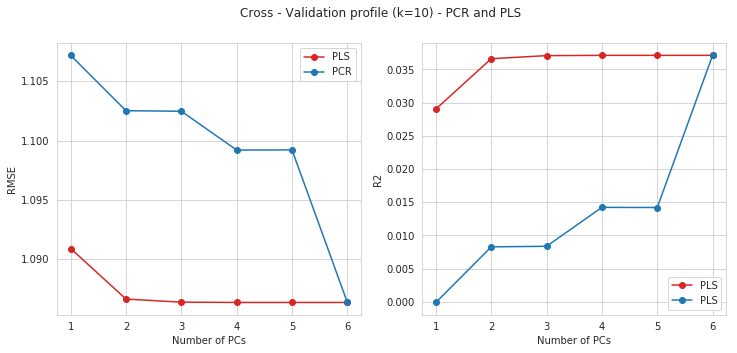

In [39]:
# Process report: plot cross-validation profile:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plt.suptitle('Cross - Validation profile (k=10) - PCR and PLS')
ax[0].plot(PCs, cv_rmsePLS,'C3-o', label='PLS')
ax[0].plot(PCs, cv_rmsePCR,'C0-o', label='PCR')
ax[0].set_xlabel('Number of PCs')
ax[0].set_ylabel('RMSE')
ax[0].legend()
# ax[0].set_ylim([1.086, 1.09])
ax[1].plot(PCs, cv_r2PLS,'C3-o', label='PLS')
ax[1].plot(PCs, cv_r2PCR,'C0-o', label='PLS')
ax[1].legend()
ax[1].set_xlabel('Number of PCs')
ax[1].set_ylabel('R2')
plt.show()
fig.savefig('hw02-figs/CV_pcr-pls.pdf')

In [15]:
# Partial least-squares: considering nº of PC = 4
# Build the model:
pls = PLSRegression(n_components=4)
# Model fitting using the training set:
pls.fit(mos_trainX.values, mos_trainY.values)

# Testing the model:
# Estimate the outcome using the transformed validation set: real data = mos_Y
pls_Y = pls.predict(mos_X.values)
# Compute the RMSE and the R2 scores using scikit-learn built-in functions
pls_rmse = np.sqrt(mean_squared_error(mos_Y, pls_Y))
pls_r2 = r2_score(mos_Y, pls_Y)

# View results:
print(f'''PLS model PCs = 2:\n
PLS performance - validation set:\n
RMSE: {pls_rmse}
R2: {pls_r2}\n
Residuals:\n {(mos_Y - pls_Y).describe()}''')

PLS model PCs = 2:

PLS performance - validation set:

RMSE: 1.0844628901880375
R2: 0.03959937729894869

Residuals:
                MOS
count  4537.000000
mean      0.013774
std       1.084495
min      -2.293488
25%      -0.591028
50%      -0.001427
75%       0.454450
max       2.505438


RMSE difference (ols_rmse): [ 0.00000000e+00 -2.42693823e-08 -8.62656612e-07  1.89321552e-06]


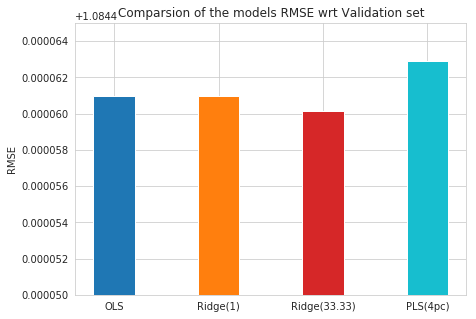

In [36]:
# Comparsion os the models - RMSE:
print(f'''RMSE difference (ols_rmse): {[ols_rmse, ridge_rmse, ridge_opt_rmse, pls_rmse] - ols_rmse}''')
plt.figure(figsize=(7, 5))
plt.title('Comparsion of the models RMSE wrt Validation set')
plt.bar([0,1,2, 3], [ols_rmse, ridge_rmse, ridge_opt_rmse, pls_rmse], 0.4, color=['C0', 'C1', 'C3', 'C9'], 
                            tick_label=['OLS', 'Ridge(1)', 'Ridge(33.33)', 'PLS(4pc)'])
plt.ylabel('RMSE')
plt.ylim([1.08445, 1.084465])#[1.086066, 1.08607])
plt.savefig('hw02-figs/rmse_barras.pdf')
plt.show()

In [17]:
# Table with the RMSE and R2 score of each model (using validation set):
df = pd.DataFrame([ols_rmse, ridge_rmse, ridge_opt_rmse, pls_rmse], 
                  index=['OLS', 'Ridge ($\lambda$=1)', 'Ridge ($\lambda$=33.33)', 'PLS (4pc)'], 
                  columns=['RMSE'])
df['R2'] = [ols_r2, ridge_r2, ridge_opt_r2, pls_r2]
pd.set_option('precision', 8)
df.head()

,RMSE,R2
OLS,1.08446100,0.03960273
Ridge ($\lambda$=1),1.08446097,0.03960277
Ridge ($\lambda$=33.33),1.08446012,0.03960428
PLS (4pc),1.08446289,0.03959938


In [18]:
dfname = 'rmse_tabela'
df.to_latex(f'hw02-tables/{dfname}.tex')